# plotting functions of figure 3 in the manuscript
In this figure, we analyse the effect of enabling radiation damage and reducing the SNR by lowering the exposure. The plots shown are:
- The output of ctffind4 for a micrograph simulated with and without radiation damage
- The B-factor of a reconstruction made from a dataset simulated with radiation damage by ResLog analysis
- The resolution of reconstructions as a function of electron dose for a dataset simulated without radiation damage
- Example 2D classes of datasets simulated with varying electron dose


In [11]:
# imports
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import mrcfile
from gemmi import cif


In [12]:
# functions
def get_resolution_from_logs(data, verbose=False):
    results ={
        "Nparticles": [],
        "res_unmasked": [],
        "res": [],
        "radiation": [],
    }
    
    # load the logfiles and retrieve the resolutions
    for _, item in data.items():
        if verbose:
            print(f"Processing {item['PostProcess']}")
        Refine3D_log = os.path.join(item["project_dir"], "Refine3D", item["Refine3D"], "run.out")
        pattern = r"Auto-refine: \+ Final resolution \(without masking\) is: (\d+(\.\d+)?)"
        with open(Refine3D_log, "r") as f:
            for line in f.readlines():
                if re.search(pattern, line):
                    res_unmasked = float(re.search(pattern, line).group(1))
                    break

        PostProcess_log = os.path.join(item["project_dir"], "PostProcess", item["PostProcess"], "run.out")
        pattern = r"\+\s*FINAL\s+RESOLUTION:\s+(\d+(\.\d+)?)"
        with open(PostProcess_log, "r") as f:
            for line in f.readlines():
                if re.search(pattern, line):
                    res = float(re.search(pattern, line).group(1))
                    break
        
        if verbose:
            print(f"Nparticles: {item['Nparticles']}")
            print(f"res_unmasked: {res_unmasked}")
            print(f"res: {res}")
        results["Nparticles"].append(item["Nparticles"])
        results["res_unmasked"].append(res_unmasked)
        results["res"].append(res)
        results["radiation"].append(item["radiation"])
    results["d^-2"] = [1/(res**2) for res in results["res"]]

    return results


## panel A
plotting the ctffind4 output for an example micrograph with and without radiation damage

saved figure to: /home/mjoosten1/projects/roodmus/data/DESRES-Trajectory_sarscov2-11021571-all-glueCA_fractionated/figures/fractionated_diagnostic.pdf
saved figure to: /home/mjoosten1/projects/roodmus/data/DESRES-Trajectory_sarscov2-11021571-all-glueCA_fractionated/figures/still_diagnostic.pdf


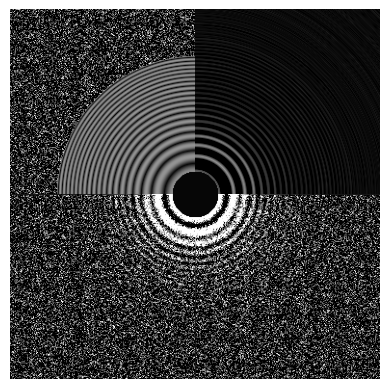

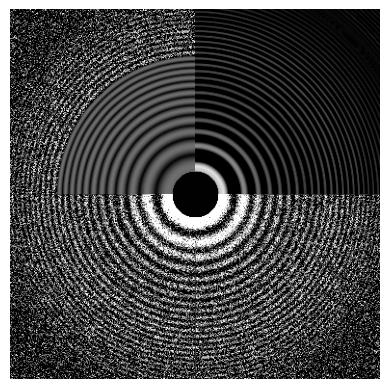

In [3]:
# load the input micrograph and plot a thumbnail
project_dir = "/home/mjoosten1/projects/roodmus/data/DESRES-Trajectory_sarscov2-11021571-all-glueCA_fractionated"
figures_dir = os.path.join(project_dir, "figures")

frac_mrc_filename = os.path.join(project_dir, "plot_ctf", "fractionated", "diagnostic_movie.mrc")
still_mrc_filename = os.path.join(project_dir, "plot_ctf", "still", "diagnostic_output.mrc")

frac_mrc = mrcfile.open(frac_mrc_filename, mode='r').data.squeeze()
factor = 8
frac_mrc = frac_mrc[frac_mrc.shape[0]//factor:-frac_mrc.shape[0]//factor, frac_mrc.shape[1]//factor:-frac_mrc.shape[1]//factor]

fig, ax = plt.subplots()
ax.imshow(frac_mrc, cmap='gray', vmin=np.percentile(frac_mrc, 30), vmax=np.percentile(frac_mrc, 99.3))
ax.axis('off')

fig.savefig(os.path.join(figures_dir, "fractionated_diagnostic.pdf"), bbox_inches='tight')
print(f"saved figure to: {os.path.join(figures_dir, 'fractionated_diagnostic.pdf')}")

still_mrc = mrcfile.open(still_mrc_filename, mode='r').data.squeeze()
factor = 8
still_mrc = still_mrc[still_mrc.shape[0]//factor:-still_mrc.shape[0]//factor, still_mrc.shape[1]//factor:-still_mrc.shape[1]//factor]

fig, ax = plt.subplots()
ax.imshow(still_mrc, cmap='gray', vmin=np.percentile(still_mrc, 30), vmax=np.percentile(still_mrc, 99.3))
ax.axis('off')

# fig.savefig(os.path.join(figures_dir, "still_diagnostic.pdf"), bbox_inches='tight')
print(f"saved figure to: {os.path.join(figures_dir, 'still_diagnostic.pdf')}")


## panel B
plot the FSC curve of both reconstructions without and with radiation damge

saved figure to: /tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/figures/FSC_rad_norad.pdf


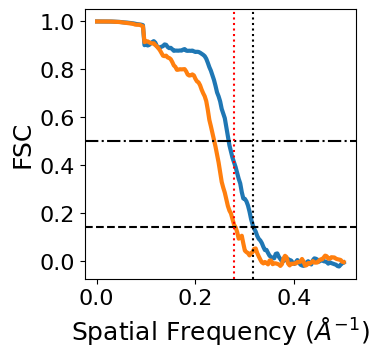

In [4]:
# load the fsc data from the reconstruction with radiation damage
project_dir = "/home/mjoosten1/projects/roodmus/data/DESRES-Trajectory_sarscov2-11021571-all-glueCA_fractionated"
figures_dir = os.path.join(project_dir, "figures")
fsc_postprocess_filename = os.path.join(project_dir, "PostProcess", "job050", "postprocess.star")
resolution = 3.6

fsc_cif = cif.read(fsc_postprocess_filename).find_block("fsc")
rlnResolution = fsc_cif.find_loop("_rlnResolution")
rlnFourierShellCorrelationCorrected = fsc_cif.find_loop("_rlnFourierShellCorrelationCorrected")
rlnFourierShellCorrelationParticleMaskFraction = fsc_cif.find_loop("_rlnFourierShellCorrelationParticleMaskFraction")
rlnFourierShellCorrelationUnmaskedMaps = fsc_cif.find_loop("_rlnFourierShellCorrelationUnmaskedMaps")
rlnFourierShellCorrelationMaskedMaps = fsc_cif.find_loop("_rlnFourierShellCorrelationMaskedMaps")
rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps = fsc_cif.find_loop("_rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps")

df = pd.DataFrame({
    "freq": rlnResolution,
    "fsc": rlnFourierShellCorrelationCorrected,
    "fsc_masked": rlnFourierShellCorrelationMaskedMaps,
    "fsc_unmasked": rlnFourierShellCorrelationUnmaskedMaps,
    "fsc_masked_random": rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps,
    "fsc_masked_fraction": rlnFourierShellCorrelationParticleMaskFraction,
    "radiation": True,
    "resolution": resolution,
})
df_all = df

# load the fsc data from the reconstruction with radiation damage
project_dir = "/tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA"
figures_dir = os.path.join(project_dir, "figures")
job = "job016"
fsc_postprocess_filename = os.path.join(project_dir, "PostProcess", job, "postprocess.star")
figures_dir = os.path.join(project_dir, "figures")
resolution = 3.17

fsc_cif = cif.read(fsc_postprocess_filename).find_block("fsc")
rlnResolution = fsc_cif.find_loop("_rlnResolution")
rlnFourierShellCorrelationCorrected = fsc_cif.find_loop("_rlnFourierShellCorrelationCorrected")
rlnFourierShellCorrelationParticleMaskFraction = fsc_cif.find_loop("_rlnFourierShellCorrelationParticleMaskFraction")
rlnFourierShellCorrelationUnmaskedMaps = fsc_cif.find_loop("_rlnFourierShellCorrelationUnmaskedMaps")
rlnFourierShellCorrelationMaskedMaps = fsc_cif.find_loop("_rlnFourierShellCorrelationMaskedMaps")
rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps = fsc_cif.find_loop("_rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps")

df = pd.DataFrame({
    "freq": rlnResolution,
    "fsc": rlnFourierShellCorrelationCorrected,
    "fsc_masked": rlnFourierShellCorrelationMaskedMaps,
    "fsc_unmasked": rlnFourierShellCorrelationUnmaskedMaps,
    "fsc_masked_random": rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps,
    "fsc_masked_fraction": rlnFourierShellCorrelationParticleMaskFraction,
    "radiation": False,
    "resolution": resolution,
})
df_all = pd.concat([df_all, df])

# convert all columns to float except the radiation column
df_all = df_all.apply(pd.to_numeric, errors="ignore")

fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.lineplot(x="freq", y="fsc", data=df_all, ax=ax, legend=True, linewidth=3, hue="radiation", palette="tab10")
# sns.lineplot(x="resolution", y="fsc_masked", data=df, ax=ax, legend=True, label="masked", linewidth=3)
# sns.lineplot(x="resolution", y="fsc_unmasked", data=df, ax=ax, legend=True, label="unmasked", linewidth=3)
ax.axhline(0.143, color="black", linestyle="--")
ax.axhline(0.5, color="black", linestyle="-.")
ax.axvline(1/3.17, color="black", linestyle="dotted")
ax.axvline(1/3.6, color="red", linestyle="dotted")
ax.set_xlabel("Spatial Frequency ($\AA^{-1}$)", fontsize=18)
ax.set_ylabel("FSC", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)

# handles, _ = ax.get_legend_handles_labels()
# labels = ["-RD", "+RD"]
# ax.legend(handles, labels, fontsize=18, loc="upper right")
ax.legend().remove()

# add in text for the resolution
# ax.text(1/3.17, 1.05, "3.17 $\AA$", fontsize=14, rotation=45, va="bottom")
# ax.text(1/3.6*0.9, 1.05, "3.6 $\AA$", fontsize=14, rotation=45, va="bottom")

# fig.savefig(os.path.join(figures_dir, f"FSC_rad_norad.pdf"), bbox_inches="tight")
print(f"saved figure to: {os.path.join(figures_dir, f'FSC_rad_norad.pdf')}")

## panel C
plot the ResLog analysis and estimate the B-factor of the dataset simulated with radiation damage

B-factor without radiation damage: 45.90231854105562
B-factor with radiation damage: 54.10373752962674
saved figure to: /home/mjoosten1/projects/roodmus/data/DESRES-Trajectory_sarscov2-11021571-all-glueCA_fractionated/figures/ResLog.pdf


/tmp/ipykernel_29052/2694840512.py:125: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels, fontsize=14)


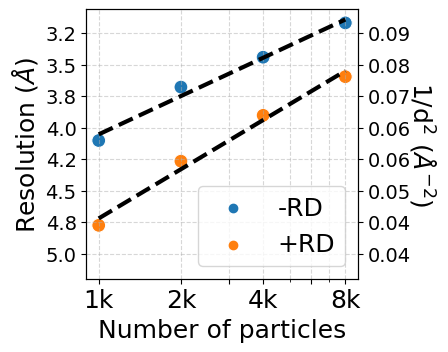

In [5]:
# plot the FSC curve and the B-factor of the reconstructed map
project_dir = "/home/mjoosten1/projects/roodmus/data/DESRES-Trajectory_sarscov2-11021571-all-glueCA_fractionated"
project_dir_norad = "/tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA"
figures_dir = os.path.join(project_dir, "figures")
data = {
    0: {
        "Nparticles": 1000,
        "Select": "job058",
        "Refine3D": "job059",
        "MaskCreate": "job053",
        "PostProcess": "job060",
        "radiation": True,
        "project_dir": project_dir,
    },
    1: {
        "Nparticles": 2000,
        "Select": "job055",
        "Refine3D": "job056",
        "MaskCreate": "job053",
        "PostProcess": "job057",
        "radiation": True,
        "project_dir": project_dir,
    },
    2: {
        "Nparticles": 4000,
        "Select": "job051",
        "Refine3D": "job052",
        "MaskCreate": "job053",
        "PostProcess": "job054",
        "radiation": True,
        "project_dir": project_dir,
    },
    3: {
        "Nparticles": 8000,
        "Select": "job045",
        "Refine3D": "job048",
        "MaskCreate": "job049",
        "PostProcess": "job050",
        "radiation": True,
        "project_dir": project_dir,
    },
    4: {
        "Nparticles": 1000,
        "Select": "job025",
        "Refine3D": "job026",
        "MaskCreate": "job027",
        "PostProcess": "job028",
        "radiation": False,
        "project_dir": project_dir_norad,
    },
    5: {
        "Nparticles": 2000,
        "Select": "job021",
        "Refine3D": "job022",
        "MaskCreate": "job023",
        "PostProcess": "job024",
        "radiation": False,
        "project_dir": project_dir_norad,
    },
    6: {
        "Nparticles": 4000,
        "Select": "job017",
        "Refine3D": "job018",
        "MaskCreate": "job019",
        "PostProcess": "job020",
        "radiation": False,
        "project_dir": project_dir_norad,
    },
    7: {
        "Nparticles": 8000,
        "Select": "job006",
        "Refine3D": "job014",
        "MaskCreate": "job015",
        "PostProcess": "job016",
        "radiation": False,
        "project_dir": project_dir_norad,
    },
}

# load the logfiles and retrieve the resolutions
results = get_resolution_from_logs(data, False)
results_df = pd.DataFrame(results)
# add column for 1/res^2
results_df["1/res2"] = 1/results_df["res"]**2
results_df["1/res_unmasked2"] = 1/results_df["res_unmasked"]**2
    
# plot the results
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.scatterplot(
    data=results_df, x="Nparticles", y="res", ax=ax, s=100, hue="radiation", palette="tab10", legend=True
)
p = np.polyfit(np.log10(results_df[results_df["radiation"]==False]["Nparticles"]), results_df[results_df["radiation"]==False]["res"], 1)
y = np.polyval(p, np.log10(results_df[results_df["radiation"]==False]["Nparticles"]))
ax.plot(results_df[results_df["radiation"]==False]["Nparticles"], y, color="black", linestyle="--", linewidth=3)
# compute B-factor as 2X slope
p = np.polyfit(np.log10(results_df[results_df["radiation"]==False]["Nparticles"]), results_df[results_df["radiation"]==False]["1/res2"], 1)
B_factor_norad = 2/p[0]
print(f"B-factor without radiation damage: {B_factor_norad}")

p = np.polyfit(np.log10(results_df[results_df["radiation"]==True]["Nparticles"]), results_df[results_df["radiation"]==True]["res"], 1)
y = np.polyval(p, np.log10(results_df[results_df["radiation"]==True]["Nparticles"]))
ax.plot(results_df[results_df["radiation"]==True]["Nparticles"], y, color="black", linestyle="--", linewidth=3)
# compute B-factor as 2X slope
p = np.polyfit(np.log10(results_df[results_df["radiation"]==True]["Nparticles"]), results_df[results_df["radiation"]==True]["1/res2"], 1)
B_factor_rad = 2/p[0]
print(f"B-factor with radiation damage: {B_factor_rad}")

ax.set_xlabel("Number of particles", fontsize=18)
ax.set_ylabel("Resolution ($\AA$)", fontsize=18)
ax.grid(axis="both", which="both", alpha=0.5, linestyle="--")
# invert x-axis
ax.set_ylim((ax.get_ylim()[0], 5.2))
ax.invert_yaxis()
# set the legend fontsize to 14 and move it to the bottom right
handles, _ = ax.get_legend_handles_labels()
labels = ["-RD", "+RD"]
ax.legend(handles=handles, labels=labels, fontsize=18, loc="lower right")


ax.set_xscale("log")
ax.set_xticks([1000, 2000, 3000, 4000, 6000, 8000])
ax.set_xticklabels(["1k", "2k", "", "4k", "", "8k"], fontsize=18)
# change y-ticklabel fontsize to 18
yticklabels = [f"{i:.1f}" for i in ax.get_yticks()]
ax.set_yticklabels(yticklabels, fontsize=14)

ax_d2 = ax.twinx()
# set the yticks for the secondary axis to 1/res^2
yticks = [1/(i**2) for i in ax.get_yticks()]
yticklabels = [f"{i:.2f}" for i in yticks]
ax_d2.set_yticks(ax.get_yticks())
ax_d2.set_yticklabels(yticklabels, fontsize=14)
ax_d2.set_ylim(ax.get_ylim())
ax_d2.set_ylabel("1/d$^2$ ($\AA^{-2}$)", fontsize=18, rotation=270, labelpad=20)

# fig.savefig(os.path.join(figures_dir, "ResLog.pdf"), bbox_inches="tight")
print(f"saved figure to: {os.path.join(figures_dir, 'ResLog.pdf')}")


## panel D
2D classes of datasets simulated with varying electron dose. Each class is ranked by RELION's automatic class ranker and the 4 highest scoring classes are shown with their resolution and the fraction of particles in the class.

exposure: 45


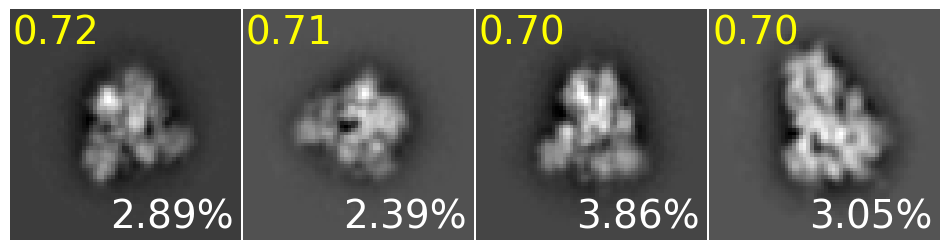

saved figure to: /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/figures/best_classes_45.pdf
exposure: 35


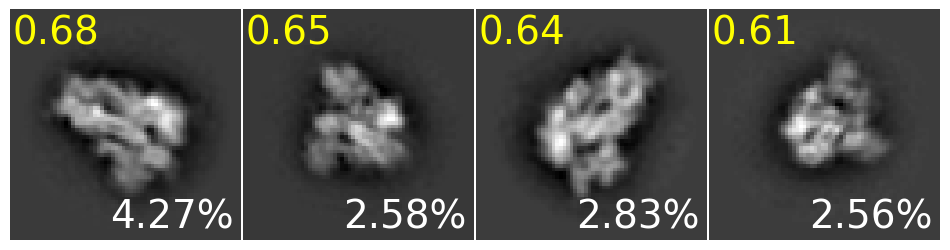

saved figure to: /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/figures/best_classes_35.pdf
exposure: 25


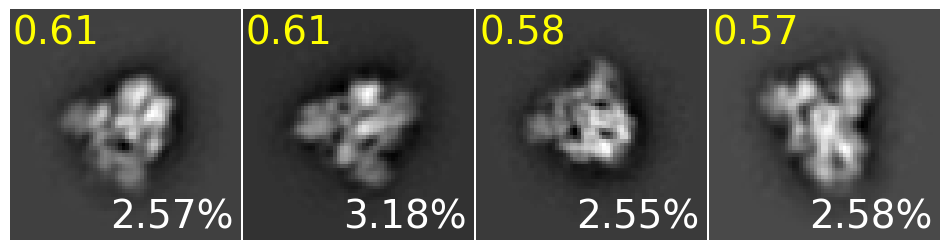

saved figure to: /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/figures/best_classes_25.pdf
exposure: 15


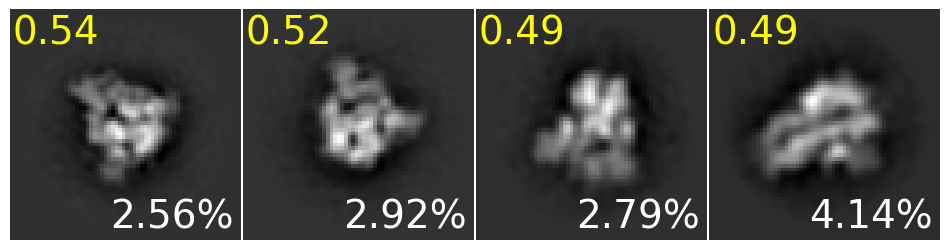

saved figure to: /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/figures/best_classes_15.pdf
exposure: 5


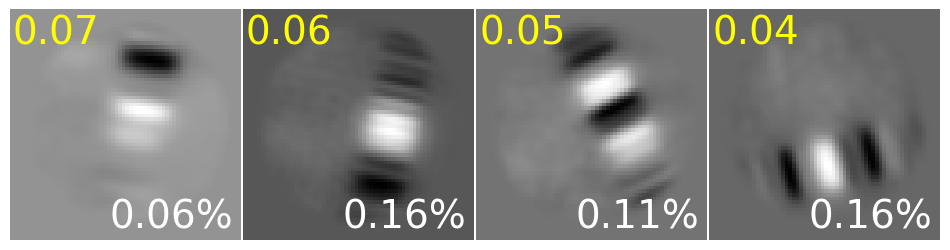

saved figure to: /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/figures/best_classes_5.pdf
exposure: 10


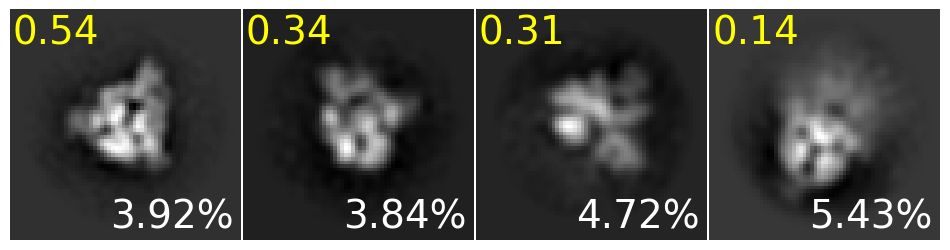

saved figure to: /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/figures/best_classes_10.pdf
exposure: 12


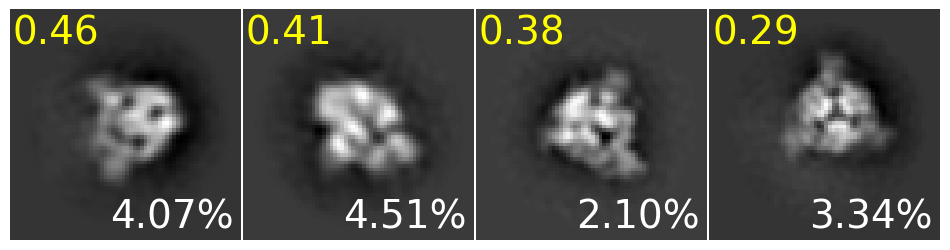

saved figure to: /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/figures/best_classes_12.pdf
exposure: 8


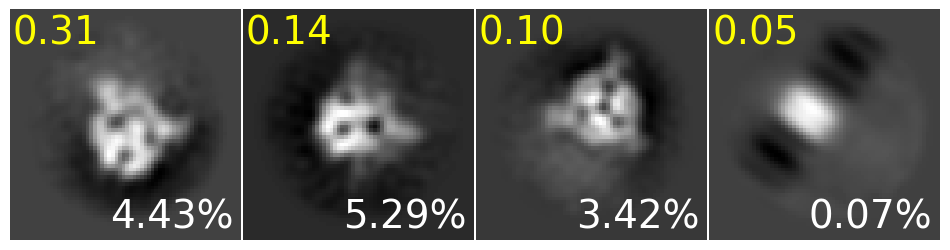

saved figure to: /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/figures/best_classes_8.pdf


In [6]:
# plotting 2D classes
project_dir = "/home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison"
figures_dir = os.path.join(project_dir, "figures")

data = {
    0: {
        "exposure": 45,
        "LoG": "job004",
        "Class2D": "job005",
        "topaz": "job010",
        "homogeneous": "job016",
        "Selection": "job100",
    },
    1: {
        "exposure": 35,
        "LoG": "job037",
        "Class2D": "job038",
        "topaz": "job042",
        "homogeneous": "job048",
        "Selection": "job102",
    },
    2: {
        "exposure": 25,
        "LoG": "job054",
        "Class2D": "job055",
        "topaz": "job059",
        "homogeneous": "job065",
        "Selection": "job103",
    },
    3: {
        "exposure": 15,
        "LoG": "job071",
        "Class2D": "job072",
        "topaz": "job076",
        "homogeneous": "job082",
        "Selection": "job106",
    },
    4: {
        "exposure": 5,
        "LoG": "job088",
        "Class2D": "job089",
        "topaz": None,
        "homogeneous": None,
        "Selection": "job107",
    },
    5: {
        "exposure": 10,
        "LoG": "job093",
        "Class2D": "job094",
        "topaz": None,
        "homogeneous": None,
        "Selection": "job108",
    },
    6: {
        "exposure": 12,
        "LoG": "job098",
        "Class2D": "job099",
        "topaz": None,
        "homogeneous": None,
        "Selection": "job109",
    },
    7: {
        "exposure": 8,
        "LoG": "job114",
        "Class2D": "job115",
        "topaz": None,
        "homogeneous": None,
        "Selection": "job116",
    }
}
N_classes = 4 # number of classes to select

for key, value in data.items():
    print(f"exposure: {value['exposure']}")
    rank_starfile = os.path.join(project_dir, "Select", value["Selection"], "rank_model.star")
    rank_cif = cif.read(rank_starfile)
    data_model_classes = rank_cif.find_block("model_classes")
    rlnClassScore = np.array(data_model_classes.find_loop("_rlnClassScore"), dtype=float)
    rlnClassDistribution = np.array(data_model_classes.find_loop("_rlnClassDistribution"), dtype=float)
    rlnEstimatedResolution = np.array(data_model_classes.find_loop("_rlnEstimatedResolution"), dtype=float)

    # get the class averages
    class_average_file = os.path.join(project_dir, "Class2D", value["Class2D"], "run_it025_classes.mrcs")
    class_average = mrcfile.open(class_average_file, mode="r")

    # select the N best classee by class score and plot them with their class score and little space between them
    idx_best_classes = np.argsort(rlnClassScore)[::-1][:N_classes]
    fig, axes = plt.subplots(1, N_classes, figsize=(N_classes * 3, 3))
    for i, idx in enumerate(idx_best_classes):
        axes[i].imshow(class_average.data[idx, :, :], cmap="gray", origin="lower")
        axes[i].text(0.2, 0.9, f"{rlnClassScore[idx]:.2f}", horizontalalignment="center", verticalalignment="center", transform=axes[i].transAxes, color="yellow", fontsize=28)
        axes[i].text(0.7, 0.1, f"{rlnClassDistribution[idx]*100:.2f}%", horizontalalignment="center", verticalalignment="center", transform=axes[i].transAxes, color="white", fontsize=28)
        # axes[i].text(0.2, 0.1, f"{rlnEstimatedResolution[idx]:.2f} $\AA$", horizontalalignment="center", verticalalignment="center", transform=axes[i].transAxes, color="white", fontsize=16)
        axes[i].axis("off")

    # reduce the space between subplots
    fig.subplots_adjust(wspace=0.01)
    plt.show()

    outfilename = os.path.join(figures_dir, f"best_classes_{value['exposure']}.pdf")
    # fig.savefig(outfilename), bbox_inches="tight")
    print(f"saved figure to: {outfilename}")


## panel E
plot the resolution of the reconstruction as a function of electron dose for a dataset simulated without radiation damage

In [7]:
# make a plot of the number of particles selected by automatic class selection as function of the exposure
project_dir = "/home/mjoosten1/projects/roodmus/data/20240207_low_exposure_data_reconstruction"
figures_dir = os.path.join(project_dir, "figures")

data = {
    0: {
        "exposure": 45,
        "Nparticles": 30000,
        "postprocess": "job008"
    },
    1: {
        "exposure": 35,
        "Nparticles": 30000,
        "postprocess": "job016",
    },
    2: {
        "exposure": 25,
        "Nparticles": 30000,
        "postprocess": "job023",
    },
    3: {
        "exposure": 15,
        "Nparticles": 30000,
        "postprocess": "job030",
    },
    4: {
        "exposure": 12,
        "Nparticles": 30000,
        "postprocess": "job037",
    },
    5: {
        "exposure": 10,
        "Nparticles": 30000,
        "postprocess": "job045",
    },
    6: {
        "exposure": 8,
        "Nparticles": 30000,
        "postprocess": "job055",
    },
    7: {
        "exposure": 5,
        "Nparticles": 30000,
        "postprocess": "job062",
    },
    8: {
        "exposure": 45,
        "Nparticles": 8000,
        "postprocess": "job066",
    },
    9: {
        "exposure": 35,
        "Nparticles": 8000,
        "postprocess": "job070",
    },
    10: {
        "exposure": 25,
        "Nparticles": 8000,
        "postprocess": "job074",
    },
    11: {
        "exposure": 15,
        "Nparticles": 8000,
        "postprocess": "job079",
    },
    12: {
        "exposure": 12,
        "Nparticles": 8000,
        "postprocess": "job084",
    },
    13: {
        "exposure": 10,
        "Nparticles": 8000,
        "postprocess": "job088",
    },
    14: {
        "exposure": 8,
        "Nparticles": 8000,
        "postprocess": "job098",
    },
}

result = {
    "exposure": [],
    "postprocess": [],
    "Nparticles": [],
}

for key, item in data.items():
    result["exposure"].append(item["exposure"])
    print(item["exposure"])

    if item["postprocess"]:
        postprocess_star = os.path.join(project_dir, "PostProcess", item["postprocess"], "postprocess.star")
        postprocess_cif = cif.read_file(postprocess_star)
        general = postprocess_cif.find_block("general")
        rlnFinalResolution = general.find_value("_rlnFinalResolution")
        result["postprocess"].append(float(rlnFinalResolution))
    else:
        result["postprocess"].append(np.nan)

    if item["Nparticles"]:
        result["Nparticles"].append(item["Nparticles"])
    else:
        result["Nparticles"].append(np.nan)


df = pd.DataFrame(result)
# df.tail()


45
35
25
15
12
10
8
5
45
35
25
15
12
10
8


/home/mjoosten1/projects/roodmus/data/20240207_low_exposure_data_reconstruction/figures/resolution_vs_exposure.pdf


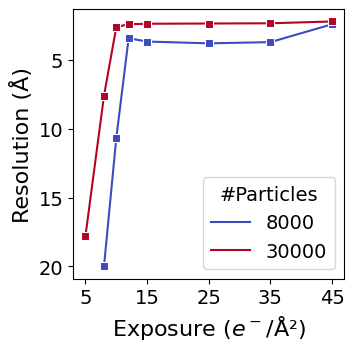

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))
# create a pallete for the 2 lines to be blue and red
sns.lineplot(x="exposure", y="postprocess", data=df, ax=ax, marker="s", color="k", hue="Nparticles", palette="coolwarm", legend="full")

# invert the y-axis
ax.invert_yaxis()
ax.set_ylabel("Resolution (Å)", fontsize=16)
ax.tick_params(labelsize=14)
ax.set_xticks([5, 15, 25, 35, 45])
ax.set_xlabel("Exposure ($e^-$/Å²)", fontsize=16)

# change the legend title to #Particles
ax.legend(title="#Particles", fontsize=14, title_fontsize=14)


# fig.savefig(os.path.join(figures_dir, "resolution_vs_exposure.pdf"), bbox_inches="tight")
print(os.path.join(figures_dir, "resolution_vs_exposure.pdf"))


## panel F
plotting the number of particles selected by the class ranker for a threshold value of 0.5 and 0.3

In [9]:
# plotting 2D classes
project_dir = "/home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison"
figures_dir = os.path.join(project_dir, "figures")

data = {
    0: {
        "exposure": 45,
        "LoG": "job004",
        "Class2D": "job005",
        "topaz": "job010",
        "homogeneous": "job016",
        "Selection": "job100",
    },
    1: {
        "exposure": 35,
        "LoG": "job037",
        "Class2D": "job038",
        "topaz": "job042",
        "homogeneous": "job048",
        "Selection": "job102",
    },
    2: {
        "exposure": 25,
        "LoG": "job054",
        "Class2D": "job055",
        "topaz": "job059",
        "homogeneous": "job065",
        "Selection": "job103",
    },
    3: {
        "exposure": 15,
        "LoG": "job071",
        "Class2D": "job072",
        "topaz": "job076",
        "homogeneous": "job082",
        "Selection": "job106",
    },
    4: {
        "exposure": 5,
        "LoG": "job088",
        "Class2D": "job089",
        "topaz": None,
        "homogeneous": None,
        "Selection": "job107",
    },
    5: {
        "exposure": 10,
        "LoG": "job093",
        "Class2D": "job094",
        "topaz": None,
        "homogeneous": None,
        "Selection": "job108",
    },
    6: {
        "exposure": 12,
        "LoG": "job098",
        "Class2D": "job099",
        "topaz": None,
        "homogeneous": None,
        "Selection": "job109",
    },
    7: {
        "exposure": 8,
        "LoG": "job114",
        "Class2D": "job115",
        "topaz": None,
        "homogeneous": None,
        "Selection": "job116",
    }
}

for key, value in data.items():
    print(f"exposure: {value['exposure']}")
    print(f"selection: {value['Selection']}")
    
    result = {
        "exposure": [],
        "class": [],
        "score": [],
        "n_particles": [],
    }

    # read the rank_model.star file to get the score per class
    rank_starfile = os.path.join(project_dir, "Select", value["Selection"], "rank_model.star")
    rank_cif = cif.read(rank_starfile)
    data_model_classes = rank_cif.find_block("model_classes")
    rlnClassScore = np.array(data_model_classes.find_loop("_rlnClassScore"), dtype=float)
    rlnReferenceImage = data_model_classes.find_loop("_rlnReferenceImage")

    result["class"] = [int(i.split("@")[0]) for i in rlnReferenceImage]
    result["score"] = rlnClassScore

    # read the rank_data.star file to obtain the number of particles per class
    data_starfile = os.path.join(project_dir, "Select", value["Selection"], "rank_data.star")
    data_cif = cif.read(data_starfile)
    data_classes = data_cif.find_block("particles")
    rlnClassNumber = np.array(data_classes.find_loop("_rlnClassNumber"), dtype=int)

    result["n_particles"] = [np.sum(rlnClassNumber == i) for i in range(1, len(result["class"])+1)]
    result["exposure"] = [value["exposure"]]*len(result["class"])

    if key == 0:
        df_total = pd.DataFrame(result)
    else:
        df = pd.DataFrame(result)
        print(f"number of unique classes: {df['class'].nunique()}")
        print(f"total number of particles: {df['n_particles'].sum()}")
        df_total = pd.concat([df_total, df])

df_total["class"] = df_total["class"].astype(int)
df_total.head()


exposure: 45
selection: job100
exposure: 35
selection: job102
number of unique classes: 50
total number of particles: 35948
exposure: 25
selection: job103
number of unique classes: 50
total number of particles: 36250
exposure: 15
selection: job106
number of unique classes: 50
total number of particles: 36346
exposure: 5
selection: job107
number of unique classes: 50
total number of particles: 36201
exposure: 10
selection: job108
number of unique classes: 50
total number of particles: 36415
exposure: 12
selection: job109
number of unique classes: 50
total number of particles: 36447
exposure: 8
selection: job116
number of unique classes: 50
total number of particles: 36361


,exposure,class,score,n_particles
0,45,1,0.027865,1791
1,45,2,-0.010480,669
2,45,3,0.033908,151
3,45,4,0.006545,156
4,45,5,0.011346,526


saved image to /home/mjoosten1/projects/roodmus/data/20231017_EMPIAR_SNR_comparison/figures/selected_classes_particles.pdf


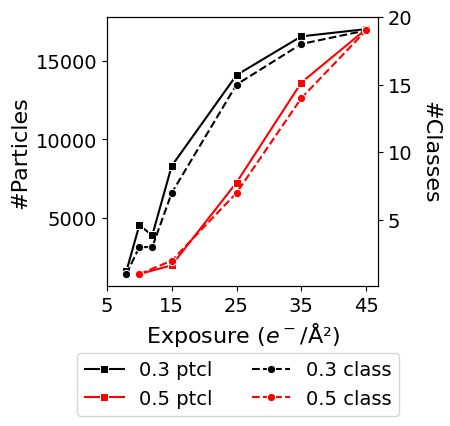

In [10]:
# plot the number of selected classes and particles with a threshold of 0.3 and 0.5

# create an aggregate dataframe with the number of selected particles and classes for a score threhsold of 0.3
fig, ax = plt.subplots(figsize=(3.5, 3.5))
ax_cl = ax.twinx()
colours = ["black", "red"]
labels = ["0.3 ptcl", "0.5 ptcl", "0.3 class", "0.5 class"]
for i, threshold in enumerate([0.3, 0.5]):
    df_plot = df_total[df_total["score"] > threshold].groupby("exposure").agg({"n_particles": "sum", "class": "nunique"}).reset_index()
    sns.lineplot(x="exposure", y="n_particles", data=df_plot, ax=ax, marker="s", color=colours[i], legend=False, label=labels[i])
    sns.lineplot(x="exposure", y="class", data=df_plot, ax=ax_cl, marker="o", color=colours[i], legend=False, linestyle="--", label=labels[i+2])

# create one legend with 4 rows: threshold 0.3, class, threshold 0.5, class to the right of the figure
handles, _ = ax.get_legend_handles_labels()
handles_cl, _ = ax_cl.get_legend_handles_labels()
handles.extend(handles_cl)
fig.legend(handles, labels, loc="center", fontsize=14, ncol=2, bbox_to_anchor=(0.5, -0.17))
ax.set_ylabel("#Particles", fontsize=16)
ax_cl.set_ylabel("#Classes", fontsize=16, rotation=270, labelpad=20)
ax.set_xlabel("Exposure ($e^-$/Å²)", fontsize=16)
ax.tick_params(labelsize=14)
ax.set_xticks([5, 15, 25, 35, 45])
ax_cl.tick_params(labelsize=14)
ax_cl.set_yticks([5, 10, 15, 20])

# fig.savefig(os.path.join(figures_dir, "selected_classes_particles.pdf"), bbox_inches="tight")
print(f"saved image to {os.path.join(figures_dir, 'selected_classes_particles.pdf')}")
